In [64]:
import json
import sys
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image as im
import imageio
from skimage import measure
import copy

In [11]:
# Read the ground truth json
bp_gt = r"C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\colon-data-reprocessed/"
bp_test = bp_gt + "test/"
IMAGE_ID = "CL_HandE_1234_B004_bottomleft"

json_gt = bp_test + IMAGE_ID+ ".json"
test_file = bp_gt + "test.csv"
info_file = bp_gt + "HuBMAP-20-dataset_information.csv"

In [27]:
df_test = pd.read_csv(test_file, index_col = "id")
df_info = pd.read_csv(info_file, index_col = "image_file") 

In [70]:
# Count the number of gloms in ground truth
read_file = open(json_gt, "r")
data = json.load(read_file)

file_name = json_gt.split('\\')[-1]
print(f'Ground truth {IMAGE_ID} has {len(data)} gloms.')

Ground truth CL_HandE_1234_B004_bottomleft has 124 gloms


In [29]:
# Read the predicted rle file
bp_pred = r"C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash - Colon"
pred_file = bp_pred + "/submission_colon_transfer.csv"

In [30]:
df_pred = pd.read_csv(pred_file)

In [31]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for m, enc in enumerate(encs):
        print (m, encs)
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m

    return img.reshape(shape).T

In [32]:
df_pred

,id,predicted
0,CL_HandE_1234_B004_bottomleft,1113145 2 1117677 8 1122212 10 1126747 12 1131...
1,HandE_B005_CL_b_RGB_bottomleft,14224597 11 14229130 20 14233663 28 14238197 3...


In [33]:
# Convert rle to mask
# shape = (47723,23990) # can read it from meta data csv 
shape = (df_info['width_pixels'][IMAGE_ID], df_info['height_pixels'][IMAGE_ID])
pred_rle = df_pred[df_pred['id'] == IMAGE_ID]["predicted"]
pred_mask = enc2mask(pred_rle, shape)

0 0    1113145 2 1117677 8 1122212 10 1126747 12 1131...
Name: predicted, dtype: object


<ipython-input-31-9d0a4c121cfb>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


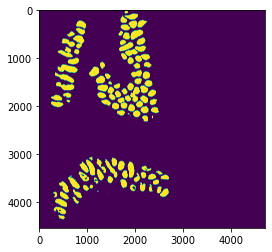

In [35]:
plt.imshow(pred_mask)

In [44]:
# Save the predicted mask as a png
data = im.fromarray(pred_mask)
MASK_PATH = 'mask_'+IMAGE_ID+'.png'
data.save(MASK_PATH)

In [49]:
PIL.Image.MAX_IMAGE_PIXELS = 1144874770
img = imageio.imread(MASK_PATH)
print ("Image loaded")

Image loaded


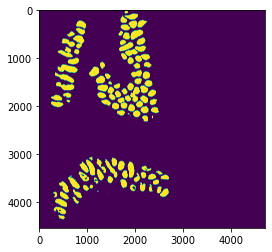

In [52]:
plt.imshow(img)

In [53]:
if len(img.shape) == 2:
    mask = img
else:
    mask = np.array(img[:, :, 0])
mask = np.where(mask > 127, 1, 0)

In [56]:
mask = img

In [67]:
contours = measure.find_contours(mask, 0.8)

# contour to polygon
polygons = []
for object in contours:
    coords = []
    for point in object:
        coords.append([int(point[0]), int(point[1])])
    polygons.append(coords)

# save as json
geojson_dict_template = {
    "type": "Feature",
    "id": "PathAnnotationObject",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
        ]
    },
    "properties": {
        "classification": {
            "name": "glomerulus",
            "colorRGB": -3140401
        },
        "isLocked": True,
        "measurements": []
    }
}
geojson_list = []
for polygon in polygons:
    geojson_dict = copy.deepcopy(geojson_dict_template)
    geojson_dict["geometry"]["coordinates"].append(polygon)
    geojson_list.append(geojson_dict)
    
# print (len(geojson_list))
# json_path = MASK_PATH.replace('png', 'json')
# with open(json_path, 'w') as fp:
#     json.dump(geojson_list, fp, indent=2)

# # polygon preview
# new_img = np.zeros((mask.shape[0], mask.shape[1]))
# for polygon in polygons:
#     for point in polygon:
#         new_img[int(point[0]), int(point[1])] = 1

123


In [72]:
print(f'Pridicted {IMAGE_ID} has {len(geojson_list)} gloms.')

Pridicted CL_HandE_1234_B004_bottomleft has 123 gloms.


In [73]:
missed = len(data) - len(geojson_list)

In [74]:
print(f'The number of missed gloms in {IMAGE_ID} are {missed}.')

The number of missed gloms in CL_HandE_1234_B004_bottomleft are 1.
